In [2]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

In [3]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [4]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

In [5]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [6]:
# Perform a left merge on 'book' to add the corresponding columns from df to books (excluding images_per_page for now)
merged_df = pd.merge(books, df[['book', 'images', 'cluster_name', 'cks', 'custom_identifier']], 
                     on='book', how='left')

# Fill NaN values with specific defaults (optional)
merged_df['cluster_name'] = merged_df['cluster_name'].fillna('Unknown')
merged_df['cks'] = merged_df['cks'].fillna('Unknown')
merged_df['custom_identifier'] = merged_df['custom_identifier'].fillna('Unknown')

#merged_df

In [7]:
#add a column with images per page data

# Step 1: Ensure 'num_pages' column is of type int
merged_df['num_pages'] = pd.to_numeric(merged_df['num_pages'], errors='coerce', downcast='integer')

# Step 2: Calculate the number of unique 'images' per 'book' and divide by 'num_pages'
# Group by 'book' to count unique images, then divide by 'num_pages' for each book
merged_df['images_per_page'] = merged_df.groupby('book')['images'].transform(lambda x: x.nunique() if x.nunique() > 0 else 0) / merged_df['num_pages']

# Step 3: Handle NaN values - books with no images or missing page counts
merged_df['images_per_page'] = merged_df['images_per_page'].fillna(0)

# Optional: Ensure books with no images (or no 'images' data) get a value of 0
merged_df.loc[merged_df['images_per_page'] == float('inf'), 'images_per_page'] = 0  # Handle division by zero

# Create the 'book_viz_level' column based on conditions
conditions = [
    (merged_df['images_per_page'] == 0),
    (merged_df['images_per_page'] > 0) & (merged_df['images_per_page'] <= 0.5),
    (merged_df['images_per_page'] > 0.5) & (merged_df['images_per_page'] < 1),
    (merged_df['images_per_page'] >= 1)
]

# Define the corresponding values for each condition
choices = ['no images', 'less or equal to 0.5 images per page', 'more than 0.5 images', 'one or more images']

# Use np.select() to apply the conditions and create the new column
merged_df['book_viz_level'] = np.select(conditions, choices, default='Unknown')

#merged_df

In [8]:
# Step 1: Convert the 'year' column to integer (if not already done), handling errors
merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce')

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1651]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Use pd.cut to categorize the years into 20-year intervals
merged_df['year_interval'] = pd.cut(merged_df['year'], bins=bins, labels=labels, right=False, include_lowest=True)

In [9]:
#cluster the places of print by number of books printed - and create "place categories"
#see if cities move between clusters if the counting is done per 20 year intervals
#cluster the number of books printed in each place category over the 20 year intervals
#cluster the number of books in each image denisty cluster by place category in the 20 year intervals

In [10]:
# Group by 'place' and count the number of unique 'book' values for each 'place'
unique_books_per_place = books.groupby('place')['book'].nunique()

# Sort the result by the number of unique books in descending order
sorted_unique_books_per_place = unique_books_per_place.sort_values(ascending=False)

# Count unique values in the 'place' column
unique_places_count = merged_df['place'].nunique()

# Print the sorted result
print(f"Number of unique places: {unique_places_count}")
print(sorted_unique_books_per_place)


Number of unique places: 43
place
Venice                        70
Paris                         69
Wittenberg                    48
Antwerp                       22
Leipzig                       19
Frankfurt (Main)              17
Lyon                          16
Cologne                       15
London                        13
Rome                           6
Strasbourg                     5
Seville                        5
Leiden                         4
Milan                          3
Saint Gervais                  3
Florence                       3
Kraków                         3
Salamanca                      3
Lisbon                         3
Bologna                        2
Madrid                         2
Sine loco                      2
Basel                          2
Lemgo                          2
Dijon                          2
Valladolid                     2
Perugia                        2
Siena                          1
Avignon                        1
Vienna   

In [11]:
# Define the updated mapping of places to categories
place_categories = {
    'Venice': 'Large centers',
    'Paris': 'Large centers',
    'Wittenberg': 'Large centers',
    'Antwerp': 'Medium centers',
    'Leipzig': 'Medium centers',
    'Frankfurt (Main)': 'Medium centers',
    'Lyon': 'Medium centers',
    'Cologne': 'Medium centers',
    'London': 'Medium centers',
    'Rome': 'Small centers',
    'Strasbourg': 'Small centers',
    'Seville': 'Small centers',
    'Leiden': 'Small centers',
    'Milan': 'Small centers',
    'Saint Gervais': 'Small centers',
    'Florence': 'Small centers',
    'Kraków': 'Small centers',
    'Salamanca': 'Small centers',
    'Lisbon': 'Small centers',
    'Bologna': 'Small centers',
    'Madrid': 'Small centers',
    'Sine loco': 'Small centers',
    'Basel': 'Small centers',
    'Lemgo': 'Small centers',
    'Dijon': 'Small centers',
    'Valladolid': 'Small centers',
    'Perugia': 'Small centers',
    'Siena': 'One book centers',
    'Avignon': 'One book centers',
    'Vienna': 'One book centers',
    'Ferrara': 'One book centers',
    'Padua': 'One book centers',
    'Nuremberg': 'One book centers',
    'Neustadt an der Weinstraße': 'One book centers',
    'Mexico City': 'One book centers',
    'Mainz': 'One book centers',
    'Coimbra': 'One book centers',
    'Leuven': 'One book centers',
    'Ingolstadt': 'One book centers',
    'Heidelberg': 'One book centers',
    'Geneva': 'One book centers',
    'Dillingen an der Donau': 'One book centers',
    'Alcalá de Henares': 'One book centers'
}

# Ensure 'place' column exists in merged_df and is in the format we expect
merged_df['place'] = merged_df['place'].astype(str)

# Create the 'place_category' column by mapping the 'place' column to categories
merged_df['place_category'] = merged_df['place'].map(place_categories)

# Group by 'place_category' and count the number of unique 'book' values and unique 'place' values in each category
unique_books_and_places_per_category = merged_df.groupby('place_category').agg(
    unique_books_count=('book', 'nunique'),
    unique_places_count=('place', 'nunique')
).reset_index()

# Print the unique place categories, the number of unique books, and the number of unique places
print(unique_books_and_places_per_category)


     place_category  unique_books_count  unique_places_count
0     Large centers                 187                    3
1    Medium centers                 102                    6
2  One book centers                  16                   16
3     Small centers                  54                   18


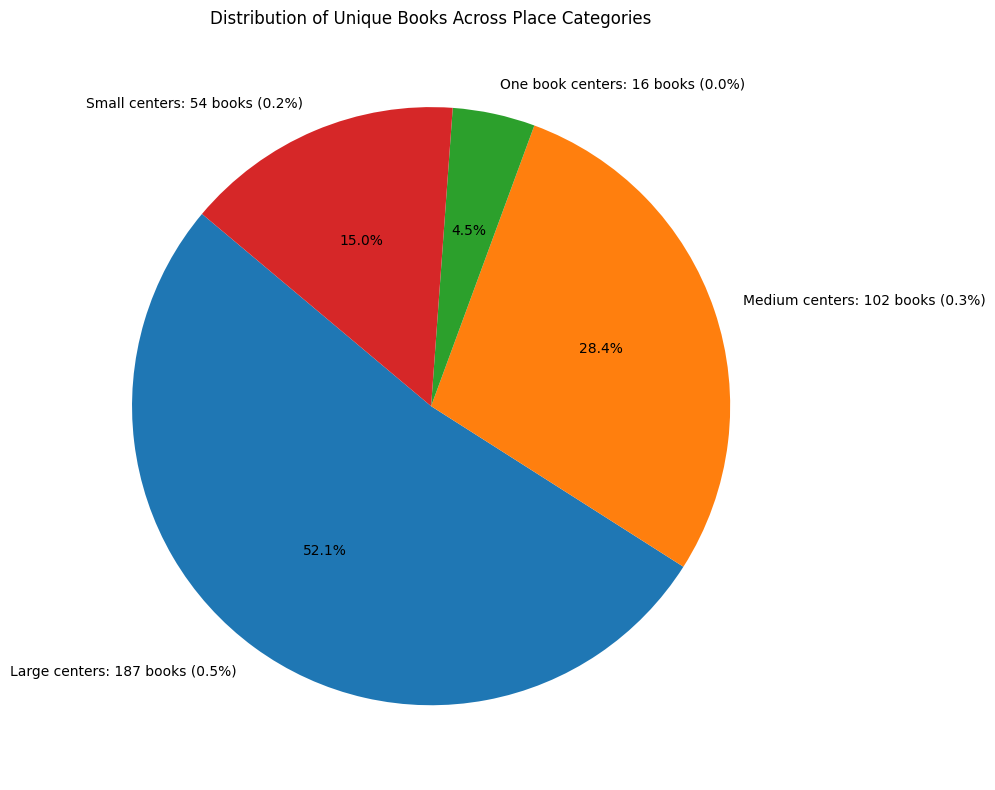

In [12]:
# Count the total number of unique book values (this is the whole pie)
total_unique_books = merged_df['book'].nunique()

# Count the number of unique books per place category
unique_books_by_category = merged_df.groupby('place_category')['book'].nunique()

# Calculate the fraction for each category (unique books in category / total unique books)
category_fractions = unique_books_by_category / total_unique_books

# Labels for the pie chart with the category names and fraction values
category_labels = [f"{category}: {unique_books} books ({fraction:.1f}%)"
                   for category, unique_books, fraction in zip(unique_books_by_category.index, unique_books_by_category, category_fractions)]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(category_fractions, labels=category_labels, autopct='%1.1f%%', startangle=140)

# Title
plt.title('Distribution of Unique Books Across Place Categories')

# Display the chart
plt.tight_layout()
plt.show()


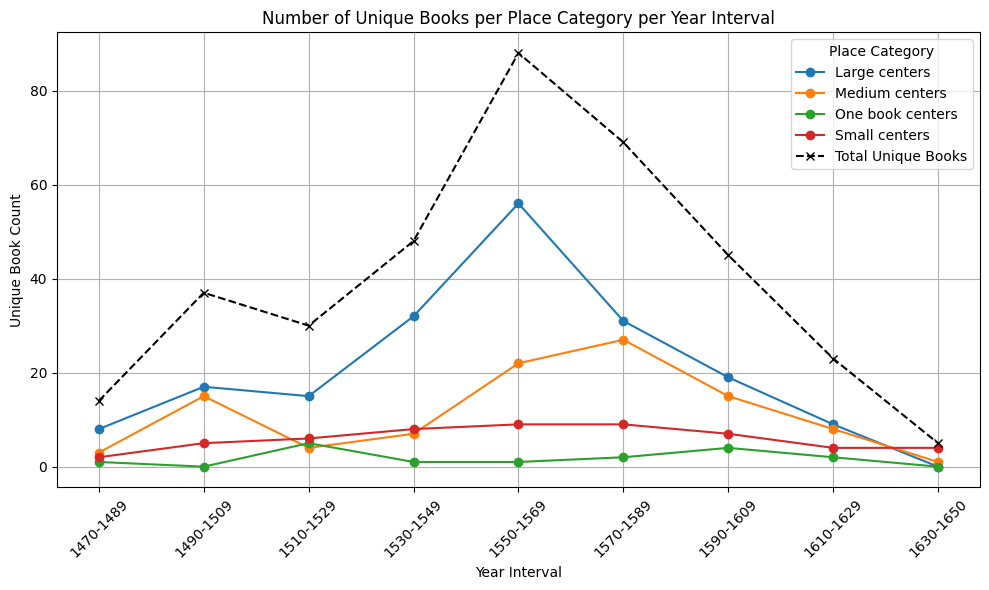

In [19]:

# Group by 'place_category' and 'year_interval', and count unique 'book' values
book_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = book_counts.pivot(index='year_interval', columns='place_category', values='book')

# Plot the line plot for place categories
ax = pivot_df.plot(kind='line', marker='o', figsize=(10, 6))

# Calculate the total number of unique books in the entire merged_df for each 'year_interval'
total_books = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Plot the total number of unique books as a broken black line
total_books.plot(kind='line', marker='x', color='black', linestyle='--', ax=ax, label='Total Unique Books')

# Customize the plot
plt.title('Number of Unique Books per Place Category per Year Interval')
plt.xlabel('Year Interval')
plt.ylabel('Unique Book Count')
plt.legend(title='Place Category')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


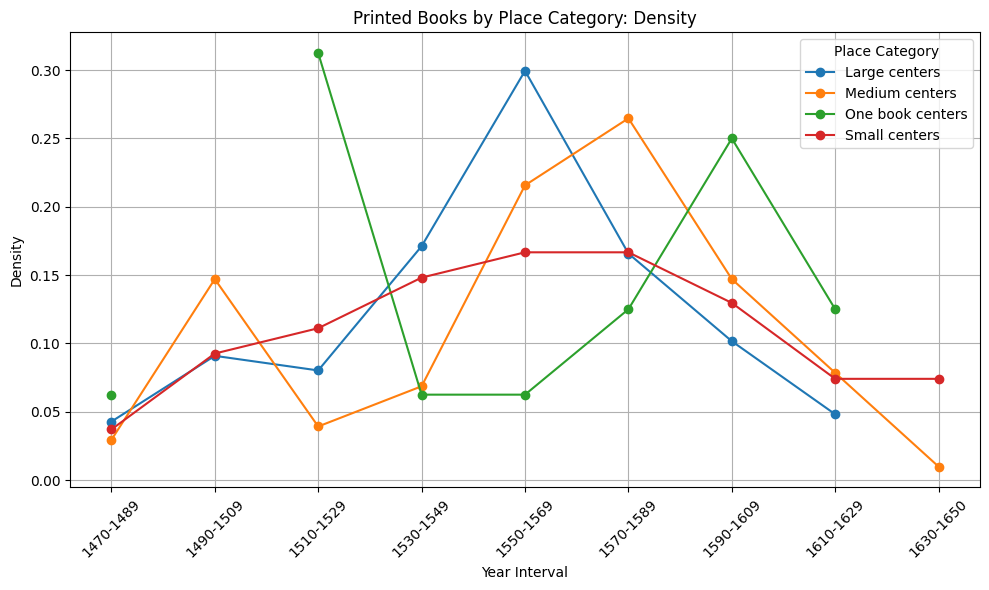

In [23]:
# Group by 'place_category' and 'interval', and count unique 'images' values
image_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = image_counts.pivot(index='year_interval', columns='place_category', values='book')

# Calculate the total number of unique images for each 'place_category'
total_images_by_category = merged_df.groupby('place_category', observed=False)['book'].nunique()

# Normalize the data by dividing the unique image counts by the total number of unique images for each 'place_category'
density_df = pivot_df.div(total_images_by_category, axis=1)

# Replace zero values with NaN to exclude them from the plot
density_df = density_df.where(density_df != 0)

# Plot the density as a line plot
ax = density_df.plot(kind='line', marker='o', figsize=(10, 6))

# Customize the plot
plt.title('Printed Books by Place Category: Density')
plt.xlabel('Year Interval')
plt.ylabel('Density')
plt.legend(title='Place Category')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


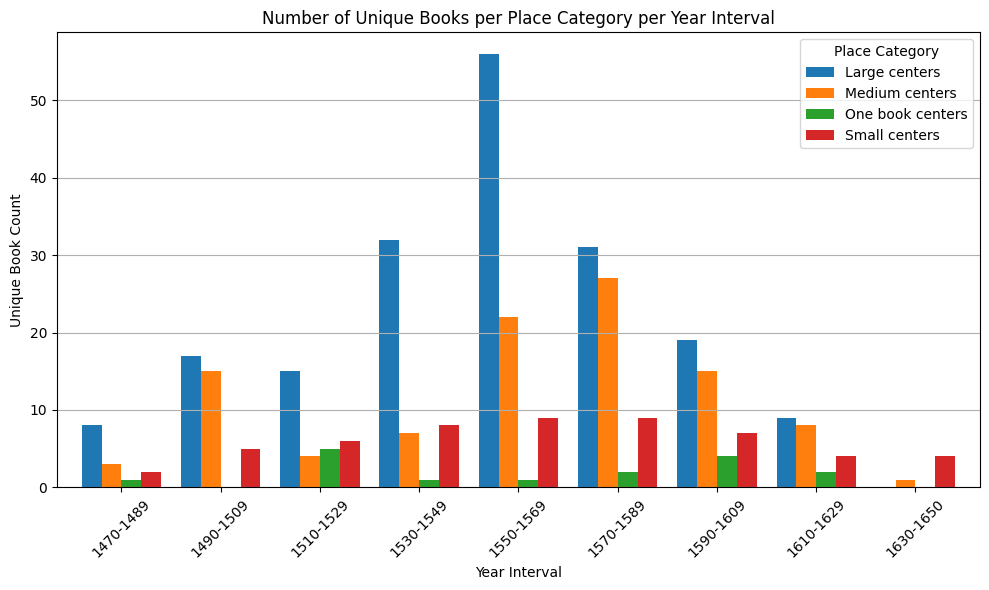

In [27]:
import matplotlib.pyplot as plt

# Group by 'place_category' and 'year_interval', and count unique 'book' values
book_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = book_counts.pivot(index='year_interval', columns='place_category', values='book')

# Plot the bar chart for place categories
ax = pivot_df.plot(kind='bar', figsize=(10, 6), width=0.8)

# Calculate the total number of unique books in the entire merged_df for each 'year_interval'
total_books = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Plot the total number of unique books as a separate black bar chart
#total_books.plot(kind='bar', width=0.2, color='black', ax=ax, label='Total Unique Books', position=-1)

# Customize the plot
plt.title('Number of Unique Books per Place Category per Year Interval')
plt.xlabel('Year Interval')
plt.ylabel('Unique Book Count')
plt.legend(title='Place Category')
plt.grid(True, axis='y')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


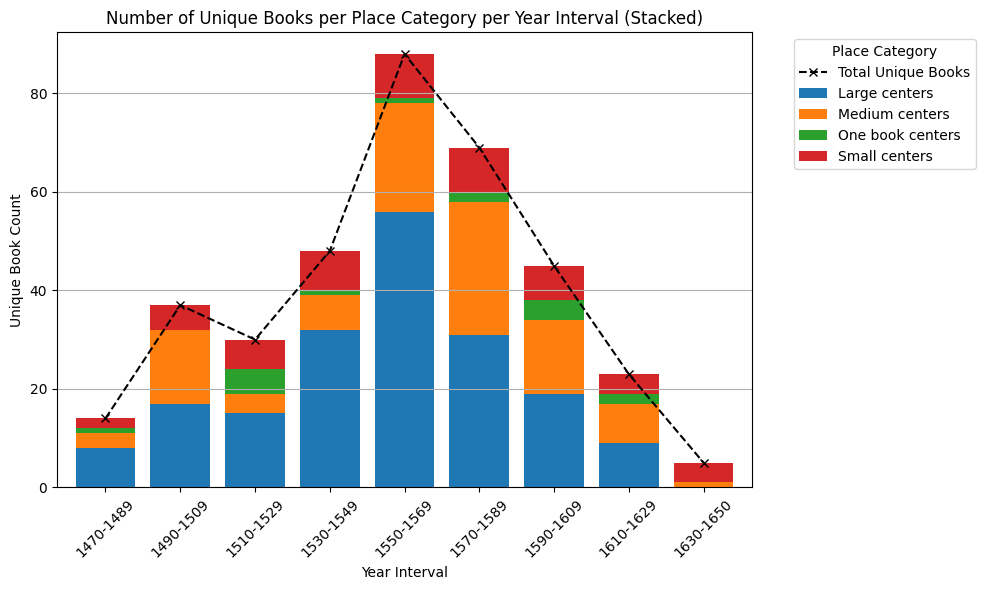

In [28]:
import matplotlib.pyplot as plt

# Group by 'place_category' and 'year_interval', and count unique 'book' values
book_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = book_counts.pivot(index='year_interval', columns='place_category', values='book')

# Plot the stacked bar chart for place categories
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8)

# Calculate the total number of unique books in the entire merged_df for each 'year_interval'
total_books = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Plot the total number of unique books as a black line on top of the stacked bars
total_books.plot(kind='line', marker='x', color='black', linestyle='--', ax=ax, label='Total Unique Books')

# Customize the plot
plt.title('Number of Unique Books per Place Category per Year Interval (Stacked)')
plt.xlabel('Year Interval')
plt.ylabel('Unique Book Count')
plt.legend(title='Place Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


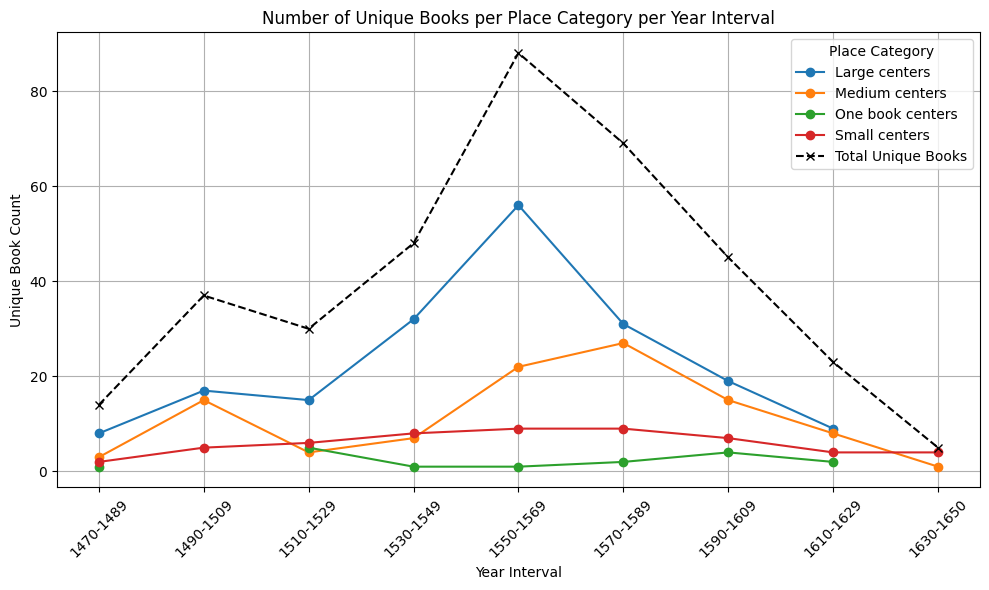

In [30]:
import matplotlib.pyplot as plt

# Group by 'place_category' and 'year_interval', and count unique 'book' values
book_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = book_counts.pivot(index='year_interval', columns='place_category', values='book')

# Replace zero values with NaN, so they won't be plotted
pivot_df = pivot_df.where(pivot_df != 0)

# Plot the line chart for place categories, ignoring zeros
ax = pivot_df.plot(kind='line', marker='o', figsize=(10, 6))

# Calculate the total number of unique books in the entire merged_df for each 'year_interval'
total_books = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Replace zero values with NaN for the total_books line as well
total_books = total_books.where(total_books != 0)

# Plot the total number of unique books as a broken black line, ignoring zeros
total_books.plot(kind='line', marker='x', color='black', linestyle='--', ax=ax, label='Total Unique Books')

# Customize the plot
plt.title('Number of Unique Books per Place Category per Year Interval')
plt.xlabel('Year Interval')
plt.ylabel('Unique Book Count')
plt.legend(title='Place Category')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


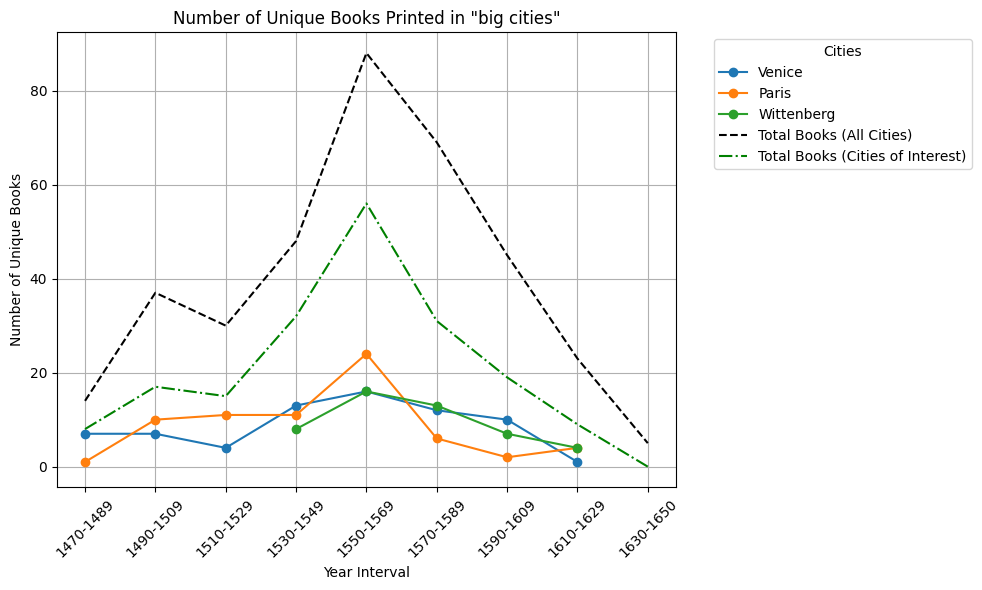

In [15]:
# Cities of interest
cities_of_interest = ['Venice', 'Paris', 'Wittenberg']

# Filter the DataFrame for these cities
filtered_df = merged_df[merged_df['place'].isin(cities_of_interest)]

# Calculate the number of unique books per city for each year_interval
unique_books_per_city_and_year = filtered_df.groupby(['year_interval', 'place'], observed=False)['book'].nunique().reset_index(name='unique_books')

# Pivot the data to make each city a column
pivot_df = unique_books_per_city_and_year.pivot(index='year_interval', columns='place', values='unique_books')

# Calculate total number of unique books in merged_df
total_books_per_year_interval = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Calculate the total number of unique books for all cities of interest together
total_books_cities_of_interest = pivot_df.sum(axis=1)

# Plot the number of unique books for each city
plt.figure(figsize=(10, 6))

# Plot each city's data (only if there are non-zero values)
for city in cities_of_interest:
    if city in pivot_df.columns:
        non_zero_data = pivot_df[city].loc[pivot_df[city] > 0]  # Only plot non-zero values
        if not non_zero_data.empty:
            plt.plot(non_zero_data.index, non_zero_data, marker='o', label=city)

# Add the black dashed line for the total number of books across all cities
plt.plot(total_books_per_year_interval.index, total_books_per_year_interval, color='black', linestyle='--', label='Total Books (All Cities)')

# Add the reference line for the total number of books across all cities of interest
plt.plot(total_books_cities_of_interest.index, total_books_cities_of_interest, color='green', linestyle='-.', label='Total Books (Cities of Interest)')

# Add labels and title
plt.title('Number of Unique Books Printed in "big cities"')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45)

# Add grid
plt.grid(True)

# Add legend
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


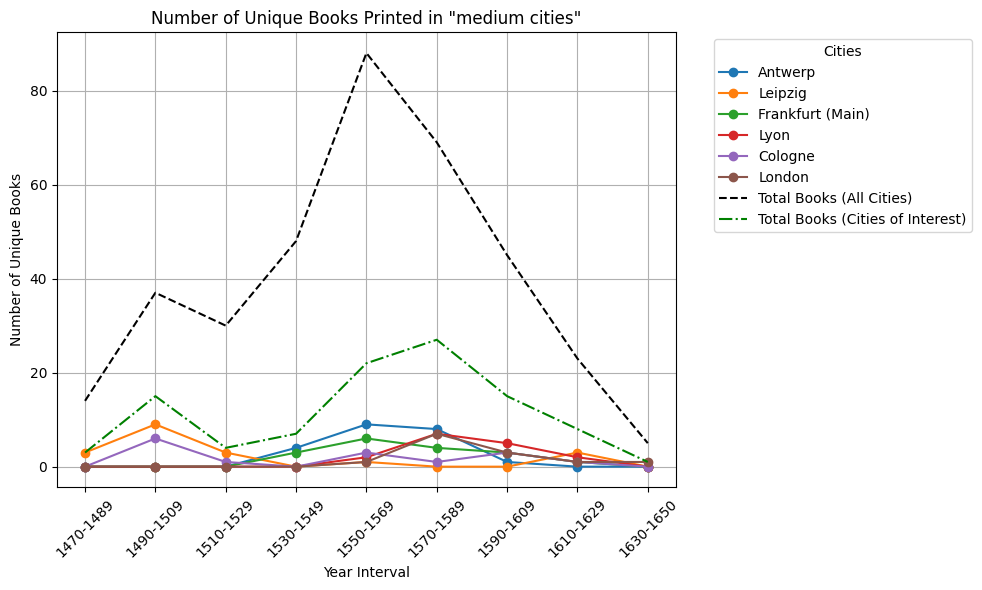

In [16]:
# Cities of interest
cities_of_interest = ['Antwerp', 'Leipzig', 'Frankfurt (Main)', 'Lyon', 'Cologne', 'London']

# Filter the DataFrame for these cities
filtered_df = merged_df[merged_df['place'].isin(cities_of_interest)]

# Calculate the number of unique books per city for each year_interval
unique_books_per_city_and_year = filtered_df.groupby(['year_interval', 'place'], observed=False)['book'].nunique().reset_index(name='unique_books')

# Pivot the data to make each city a column
pivot_df = unique_books_per_city_and_year.pivot(index='year_interval', columns='place', values='unique_books')

# Ensure all year intervals are represented for each city
all_year_intervals = sorted(pivot_df.index.unique())  # List of all unique year intervals
pivot_df = pivot_df.reindex(all_year_intervals, fill_value=0)  # Fill missing years with 0

# Calculate total number of unique books in merged_df
total_books_per_year_interval = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Calculate the total number of unique books for all cities of interest together
total_books_cities_of_interest = pivot_df.sum(axis=1)

# Plot the number of unique books for each city
plt.figure(figsize=(10, 6))

# Plot each city's data
for city in cities_of_interest:
    if city in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[city], marker='o', label=city)

# Add the black dashed line for the total number of books across all cities
plt.plot(total_books_per_year_interval.index, total_books_per_year_interval, color='black', linestyle='--', label='Total Books (All Cities)')

# Add the reference line for the total number of books across all cities of interest
plt.plot(total_books_cities_of_interest.index, total_books_cities_of_interest, color='green', linestyle='-.', label='Total Books (Cities of Interest)')

# Add labels and title
plt.title('Number of Unique Books Printed in "medium cities"')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45)

# Add grid
plt.grid(True)

# Add legend
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


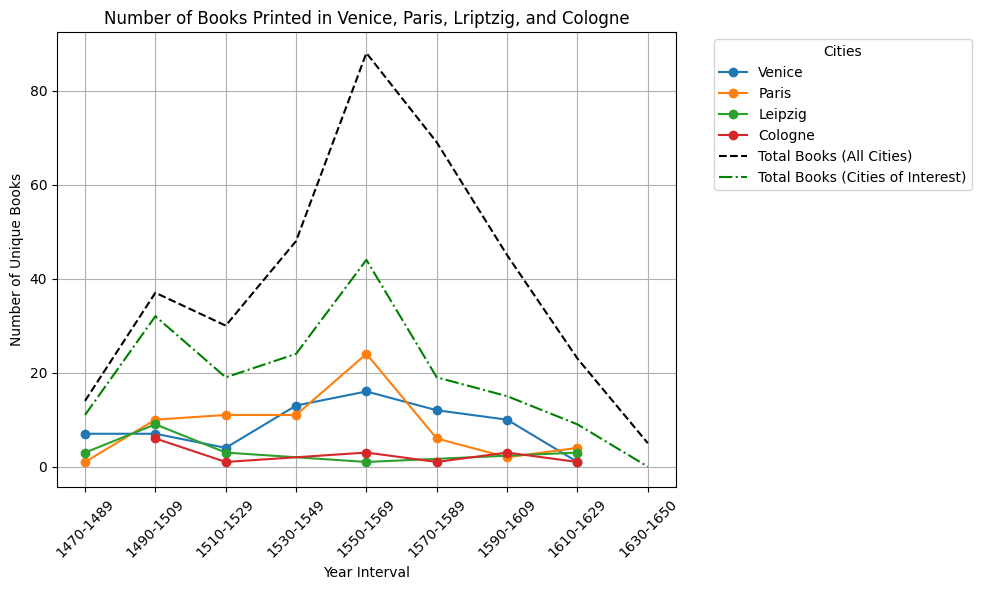

In [17]:
# Cities of interest
cities_of_interest = ['Venice', 'Paris', 'Leipzig', 'Cologne']

# Filter the DataFrame for these cities
filtered_df = merged_df[merged_df['place'].isin(cities_of_interest)]

# Calculate the number of unique books per city for each year_interval
unique_books_per_city_and_year = filtered_df.groupby(['year_interval', 'place'], observed=False)['book'].nunique().reset_index(name='unique_books')

# Pivot the data to make each city a column
pivot_df = unique_books_per_city_and_year.pivot(index='year_interval', columns='place', values='unique_books')

# Calculate total number of unique books in merged_df
total_books_per_year_interval = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Calculate the total number of unique books for all cities of interest together
total_books_cities_of_interest = pivot_df.sum(axis=1)

# Plot the number of unique books for each city
plt.figure(figsize=(10, 6))

# Plot each city's data (only if there are non-zero values)
for city in cities_of_interest:
    if city in pivot_df.columns:
        non_zero_data = pivot_df[city].loc[pivot_df[city] > 0]  # Only plot non-zero values
        if not non_zero_data.empty:
            plt.plot(non_zero_data.index, non_zero_data, marker='o', label=city)

# Add the black dashed line for the total number of books across all cities
plt.plot(total_books_per_year_interval.index, total_books_per_year_interval, color='black', linestyle='--', label='Total Books (All Cities)')

# Add the reference line for the total number of books across all cities of interest
plt.plot(total_books_cities_of_interest.index, total_books_cities_of_interest, color='green', linestyle='-.', label='Total Books (Cities of Interest)')

# Add labels and title
plt.title('Number of Books Printed in Venice, Paris, Lriptzig, and Cologne')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45)

# Add grid
plt.grid(True)

# Add legend
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


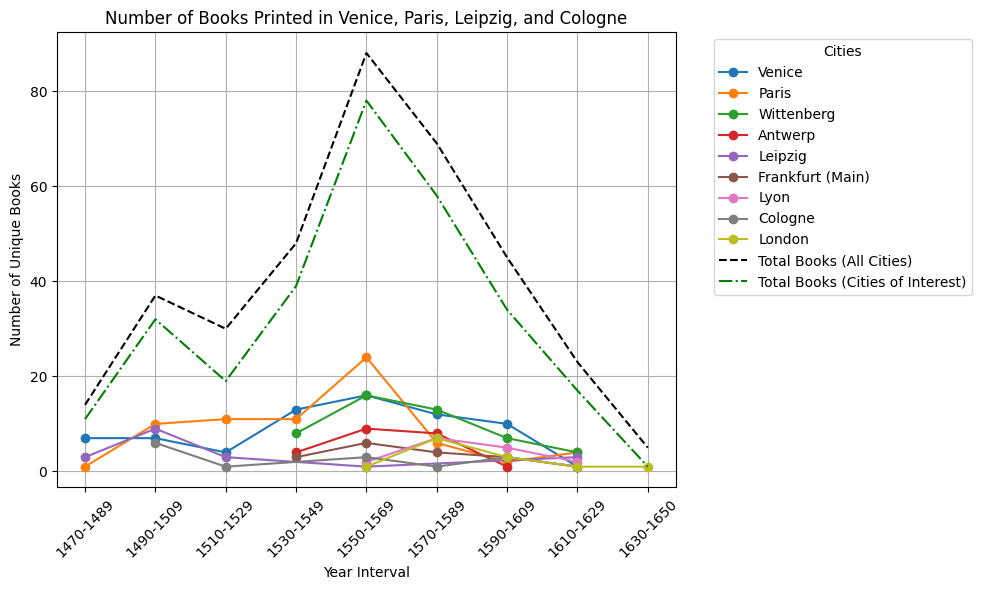

In [33]:
import matplotlib.pyplot as plt

# Cities of interest
cities_of_interest = ['Venice', 'Paris', 'Wittenberg', 'Antwerp', 'Leipzig', 'Frankfurt (Main)', 'Lyon', 'Cologne', 'London']

# Filter the DataFrame for these cities
filtered_df = merged_df[merged_df['place'].isin(cities_of_interest)]

# Calculate the number of unique books per city for each year_interval
unique_books_per_city_and_year = filtered_df.groupby(['year_interval', 'place'], observed=False)['book'].nunique().reset_index(name='unique_books')

# Pivot the data to make each city a column
pivot_df = unique_books_per_city_and_year.pivot(index='year_interval', columns='place', values='unique_books')

# Replace zero values with NaN to exclude them from the plot
pivot_df = pivot_df.where(pivot_df != 0)

# Calculate total number of unique books in merged_df
total_books_per_year_interval = merged_df.groupby('year_interval', observed=False)['book'].nunique()

# Replace zero values with NaN for total_books_per_year_interval as well
total_books_per_year_interval = total_books_per_year_interval.where(total_books_per_year_interval != 0)

# Calculate the total number of unique books for all cities of interest together
total_books_cities_of_interest = pivot_df.sum(axis=1)

# Plot the number of unique books for each city
plt.figure(figsize=(10, 6))

# Plot each city's data (only if there are non-zero values)
for city in cities_of_interest:
    if city in pivot_df.columns:
        non_zero_data = pivot_df[city].dropna()  # Only plot non-zero values
        if not non_zero_data.empty:
            plt.plot(non_zero_data.index, non_zero_data, marker='o', label=city)

# Add the black dashed line for the total number of books across all cities
plt.plot(total_books_per_year_interval.index, total_books_per_year_interval, color='black', linestyle='--', label='Total Books (All Cities)')

# Add the reference line for the total number of books across all cities of interest
plt.plot(total_books_cities_of_interest.index, total_books_cities_of_interest, color='green', linestyle='-.', label='Total Books (Cities of Interest)')

# Add labels and title
plt.title('Number of Books Printed in Venice, Paris, Leipzig, and Cologne')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45)

# Add grid
plt.grid(True)

# Add legend
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


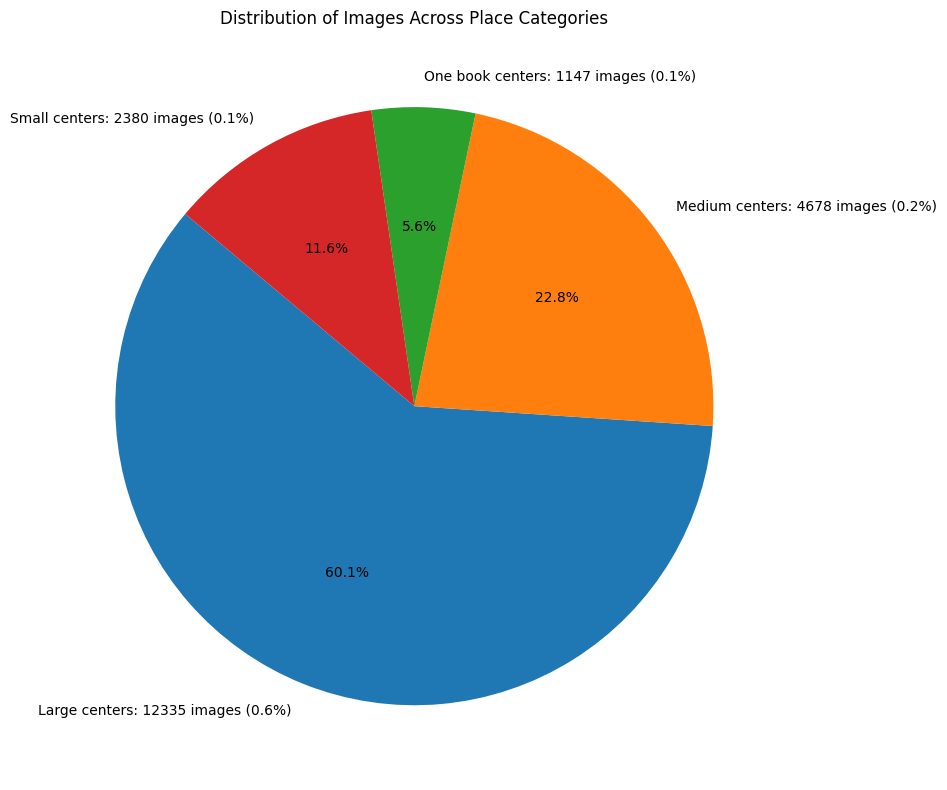

In [18]:
# Count the total number of unique book values (this is the whole pie)
total_unique_images = merged_df['images'].nunique()

# Count the number of unique books per place category
unique_images_by_category = merged_df.groupby('place_category')['images'].nunique()

# Calculate the fraction for each category (unique books in category / total unique books)
category_fractions = unique_images_by_category / total_unique_images

# Labels for the pie chart with the category names and fraction values
category_labels = [f"{category}: {unique_images} images ({fraction:.1f}%)"
                   for category, unique_images, fraction in zip(unique_images_by_category.index, unique_images_by_category, category_fractions)]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(category_fractions, labels=category_labels, autopct='%1.1f%%', startangle=140)

# Title
plt.title('Distribution of Images Across Place Categories')

# Display the chart
plt.tight_layout()
plt.show()


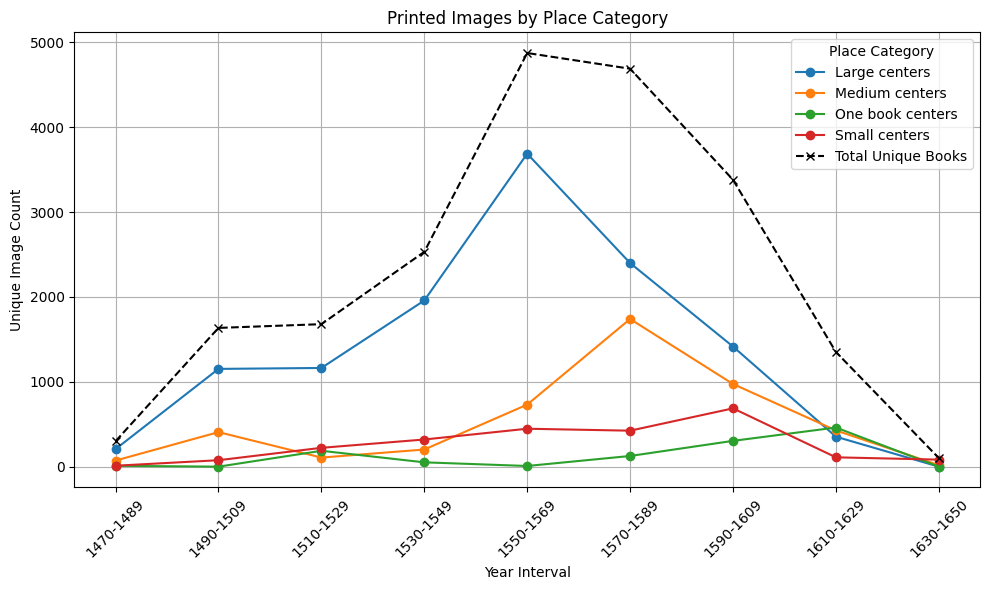

In [21]:

# Group by 'place_category' and 'year_interval', and count unique 'book' values
image_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['images'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = image_counts.pivot(index='year_interval', columns='place_category', values='images')

# Plot the line plot for place categories
ax = pivot_df.plot(kind='line', marker='o', figsize=(10, 6))

# Calculate the total number of unique books in the entire merged_df for each 'year_interval'
total_images = merged_df.groupby('year_interval', observed=False)['images'].nunique()

# Plot the total number of unique books as a broken black line
total_images.plot(kind='line', marker='x', color='black', linestyle='--', ax=ax, label='Total Unique Books')

# Customize the plot
plt.title('Printed Images by Place Category')
plt.xlabel('Year Interval')
plt.ylabel('Unique Image Count')
plt.legend(title='Place Category')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


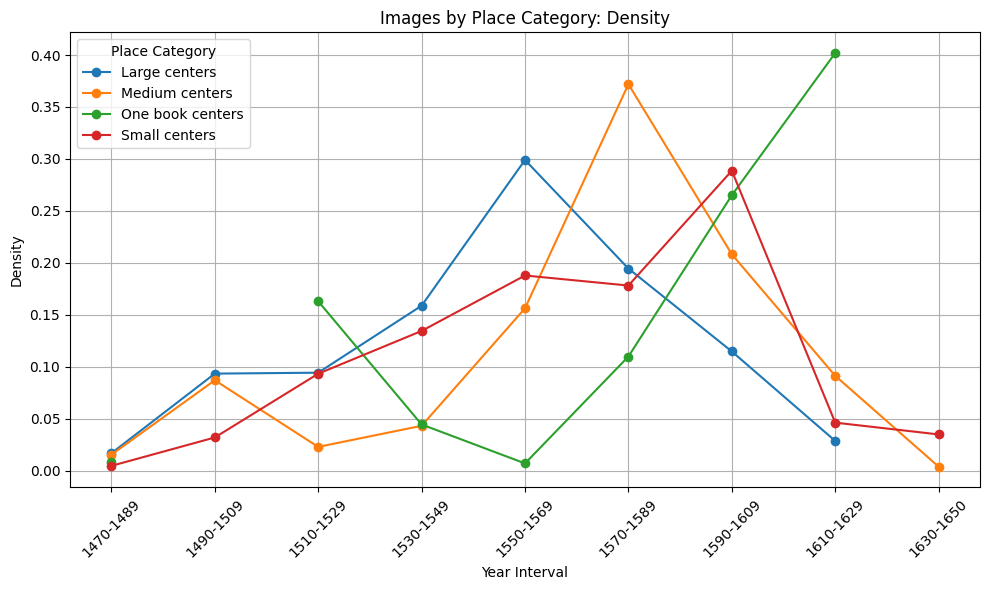

In [22]:
# Group by 'place_category' and 'interval', and count unique 'images' values
image_counts = merged_df.groupby(['place_category', 'year_interval'], observed=False)['images'].nunique().reset_index()

# Pivot the data to have 'place_category' as columns and 'year_interval' as rows
pivot_df = image_counts.pivot(index='year_interval', columns='place_category', values='images')

# Calculate the total number of unique images for each 'place_category'
total_images_by_category = merged_df.groupby('place_category', observed=False)['images'].nunique()

# Normalize the data by dividing the unique image counts by the total number of unique images for each 'place_category'
density_df = pivot_df.div(total_images_by_category, axis=1)

# Replace zero values with NaN to exclude them from the plot
density_df = density_df.where(density_df != 0)

# Plot the density as a line plot
ax = density_df.plot(kind='line', marker='o', figsize=(10, 6))

# Customize the plot
plt.title('Images by Place Category: Density')
plt.xlabel('Year Interval')
plt.ylabel('Density')
plt.legend(title='Place Category')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()


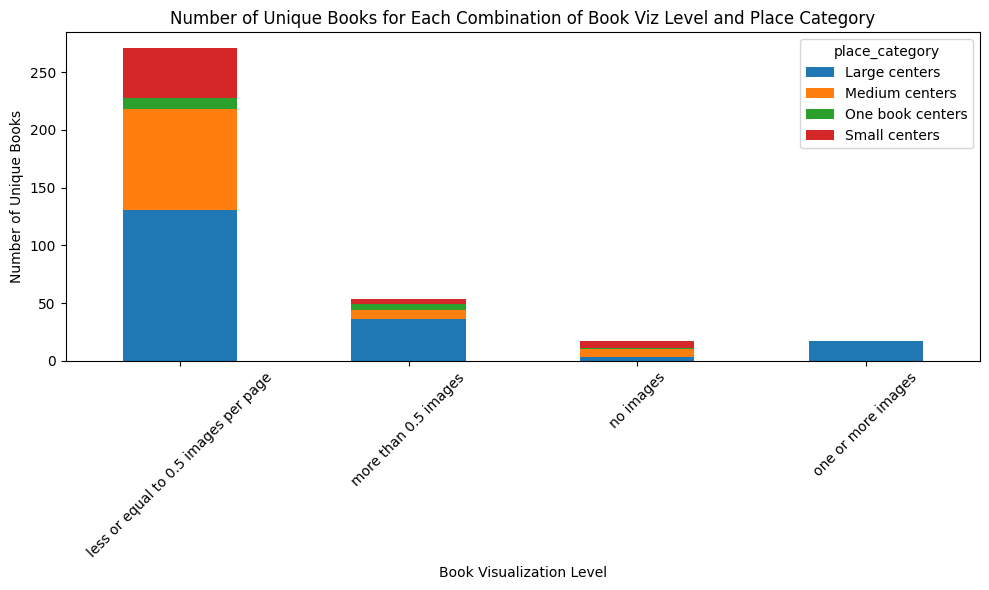

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'book_viz_level' and 'place_category', and count the number of unique books
book_counts = merged_df.groupby(['book_viz_level', 'place_category'])['book'].nunique().unstack()

# Plot the data as a stacked bar chart
book_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Number of Unique Books for Each Combination of Book Viz Level and Place Category')
plt.xlabel('Book Visualization Level')
plt.ylabel('Number of Unique Books')
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()


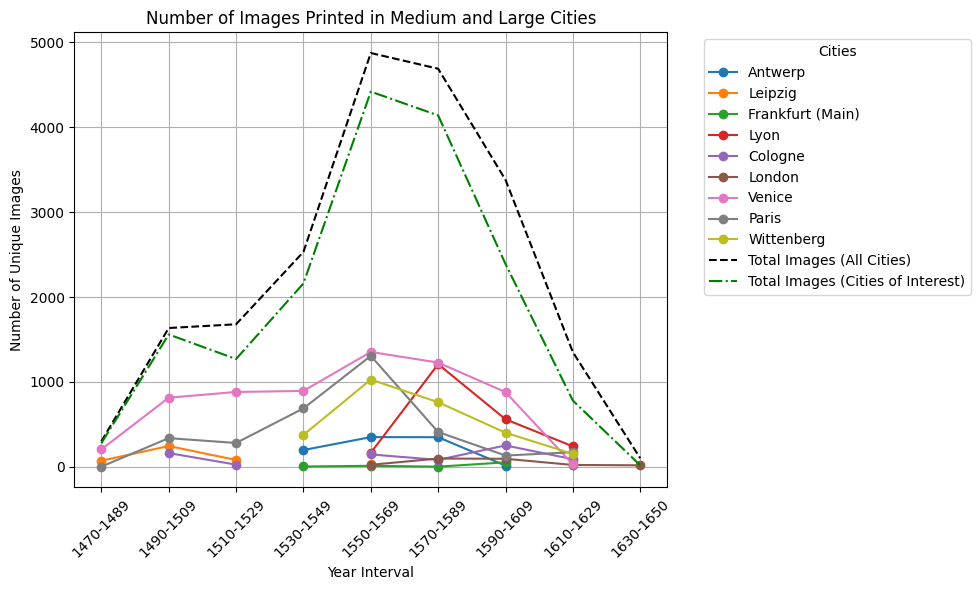

In [32]:
import matplotlib.pyplot as plt

# Cities of interest
cities_of_interest = ['Antwerp', 'Leipzig', 'Frankfurt (Main)', 'Lyon', 'Cologne', 'London', 'Venice', 'Paris', 'Wittenberg']

# Filter the DataFrame for these cities
filtered_df = merged_df[merged_df['place'].isin(cities_of_interest)]

# Calculate the number of unique images per city for each year_interval
unique_images_per_city_and_year = filtered_df.groupby(['year_interval', 'place'], observed=False)['images'].nunique().reset_index(name='unique_images')

# Pivot the data to make each city a column
pivot_df = unique_images_per_city_and_year.pivot(index='year_interval', columns='place', values='unique_images')

# Ensure all year intervals are represented for each city
all_year_intervals = sorted(pivot_df.index.unique())  # List of all unique year intervals
pivot_df = pivot_df.reindex(all_year_intervals, fill_value=0)  # Fill missing years with 0

# Replace zero values with NaN to avoid plotting lines or dots for them
pivot_df = pivot_df.where(pivot_df != 0)

# Calculate total number of unique images in merged_df
total_images_per_year_interval = merged_df.groupby('year_interval', observed=False)['images'].nunique()

# Replace zero values with NaN for total images as well
total_images_per_year_interval = total_images_per_year_interval.where(total_images_per_year_interval != 0)

# Calculate the total number of unique images for all cities of interest together
total_images_cities_of_interest = pivot_df.sum(axis=1)

# Plot the number of unique images for each city
plt.figure(figsize=(10, 6))

# Plot each city's data
for city in cities_of_interest:
    if city in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[city], marker='o', label=city)

# Add the black dashed line for the total number of images across all cities
plt.plot(total_images_per_year_interval.index, total_images_per_year_interval, color='black', linestyle='--', label='Total Images (All Cities)')

# Add the reference line for the total number of images across all cities of interest
plt.plot(total_images_cities_of_interest.index, total_images_cities_of_interest, color='green', linestyle='-.', label='Total Images (Cities of Interest)')

# Add labels and title
plt.title('Number of Images Printed in Medium and Large Cities')
plt.xlabel('Year Interval')
plt.ylabel('Number of Unique Images')
plt.xticks(rotation=45)

# Add grid
plt.grid(True)

# Add legend
plt.legend(title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

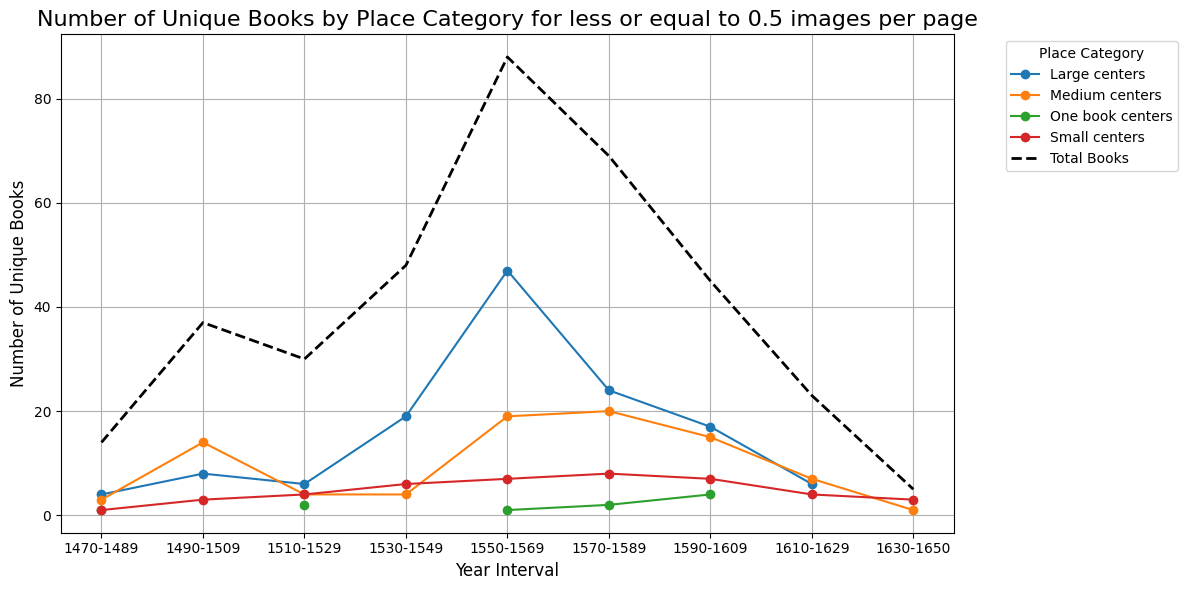

<Figure size 1200x600 with 0 Axes>

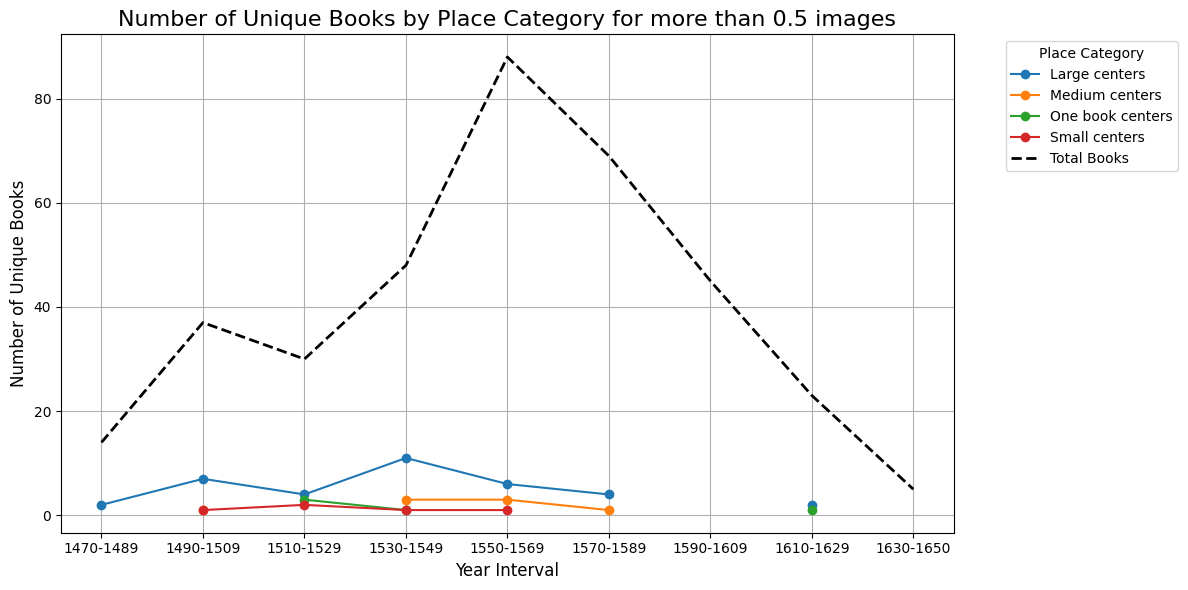

<Figure size 1200x600 with 0 Axes>

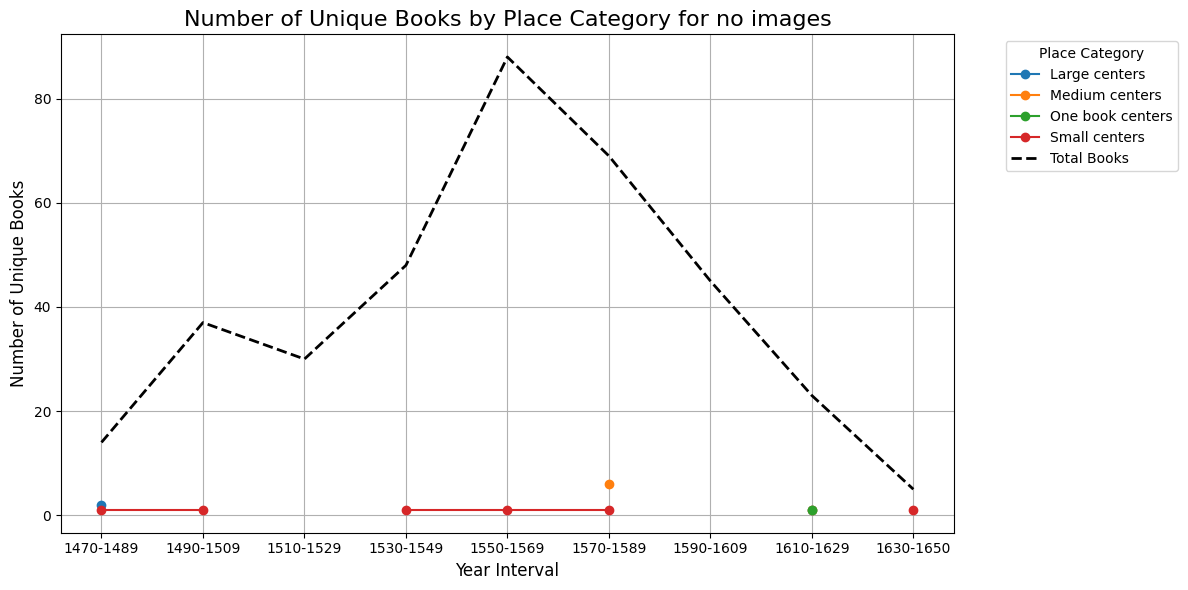

<Figure size 1200x600 with 0 Axes>

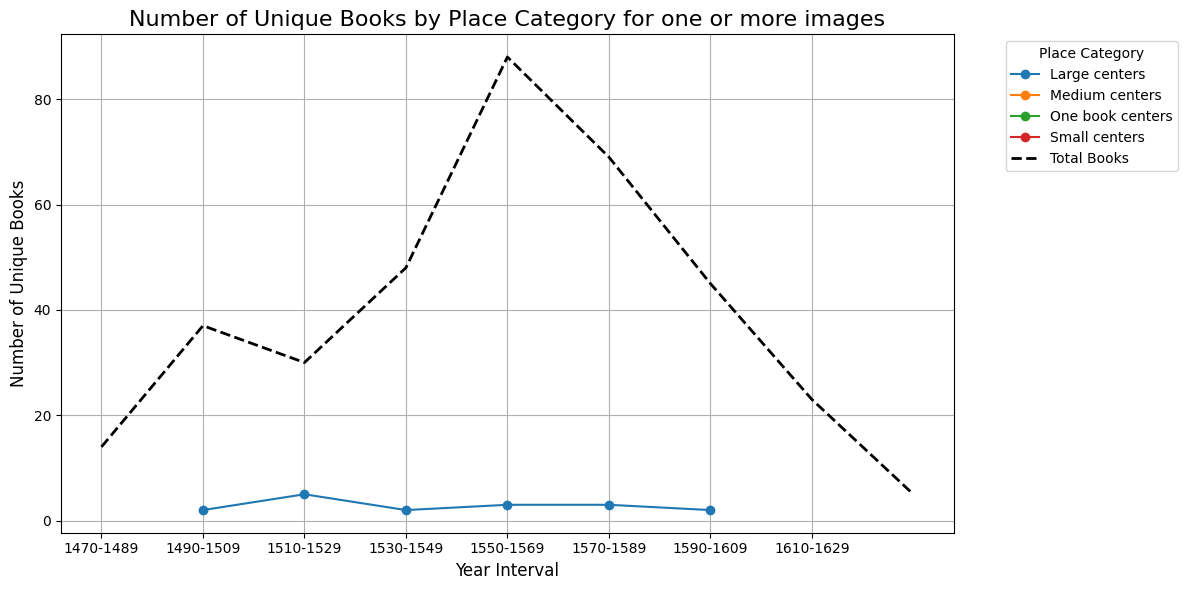

In [22]:

# Group by 'book_viz_level', 'place_category', and 'year_interval' and count unique books
book_counts_by_year = merged_df.groupby(['book_viz_level', 'place_category', 'year_interval'], observed=False)['book'].nunique().reset_index()

# List of unique book visualization levels
book_viz_levels = book_counts_by_year['book_viz_level'].unique()

# Create a plot for each book visualization level
for viz_level in book_viz_levels:
    # Filter the data for the current book visualization level
    viz_level_data = book_counts_by_year[book_counts_by_year['book_viz_level'] == viz_level]
    
    # Pivot the data to have 'place_category' as columns and 'year_interval' as index
    pivot_data = viz_level_data.pivot(index='year_interval', columns='place_category', values='book')

    # Replace zero values with NaN to avoid plotting them
    pivot_data = pivot_data.replace(0, np.nan)

    # Calculate the total unique books for each 'year_interval' across the entire merged_df dataset
    total_books = merged_df.groupby('year_interval', observed=False)['book'].nunique()

    # Create a figure for the plot
    plt.figure(figsize=(12, 6))

    # Plot the place categories (NaN values will not be plotted)
    pivot_data.plot(kind='line', marker='o', figsize=(12, 6))

    # Plot the total books reference line (black dashed line)
    plt.plot(total_books.index, total_books.values, 'k--', label='Total Books', linewidth=2)

    # Add title and labels
    plt.title(f'Number of Unique Books by Place Category for {viz_level}', fontsize=16)
    plt.xlabel('Year Interval', fontsize=12)
    plt.ylabel('Number of Unique Books', fontsize=12)
    
    # Add legend (Place Category and the total books reference line)
    plt.legend(title='Place Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show grid and tighten layout
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
